In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

df_cash = pd.read_csv("project_dataset/extract - cash request - data analyst.csv")
df_fees = pd.read_csv("project_dataset/extract - fees - data analyst - .csv")

df_cash.head()


,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update
0,5,100.0,rejected,2019-12-10 19:05:21.596873+00,2019-12-11 16:47:42.40783+00,804.0,2019-12-11 16:47:42.405646+00,NaN,2020-01-09 19:05:21.596363+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
1,70,100.0,rejected,2019-12-10 19:50:12.34778+00,2019-12-11 14:24:22.900054+00,231.0,2019-12-11 14:24:22.897988+00,NaN,2020-01-09 19:50:12.34778+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
2,7,100.0,rejected,2019-12-10 19:13:35.82546+00,2019-12-11 09:46:59.779773+00,191.0,2019-12-11 09:46:59.777728+00,NaN,2020-01-09 19:13:35.825041+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
3,10,99.0,rejected,2019-12-10 19:16:10.880172+00,2019-12-18 14:26:18.136163+00,761.0,2019-12-18 14:26:18.128407+00,NaN,2020-01-09 19:16:10.879606+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
4,1594,100.0,rejected,2020-05-06 09:59:38.877376+00,2020-05-07 09:21:55.34008+00,7686.0,2020-05-07 09:21:55.320193+00,NaN,2020-06-05 22:00:00+00,NaN,NaN,regular,NaN,NaN,NaN,NaN


## Data Cleaning & Preprocessing

In [10]:
# Drop rows with missing user_id in cash
df_cash = df_cash.dropna(subset=['user_id'])

# Convert  date columns to real date time
df_cash['created_at'] = pd.to_datetime(df_cash['created_at'])

## Creating Cohorts

We define each user’s cohort as the month when they made their first cash advance.

In [11]:
# Create a cohort column (as Period: YYYY-MM)
df_cash['cohort_month'] = df_cash.groupby('user_id')['created_at'].transform('min').dt.to_period('M')

# Also create a column for the transaction’s month
df_cash['transaction_month'] = df_cash['created_at'].dt.to_period('M')

# Now create a cohort index: number of months since cohort start.
df_cash['cohort_index'] = (df_cash['transaction_month'] - df_cash['cohort_month']).apply(lambda x: x.n)

# Quick check:
df_cash[['user_id','created_at','cohort_month','transaction_month','cohort_index']].head(10)


C:\Users\Mirko\AppData\Local\Temp\ipykernel_2688\1773421427.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_cash['cohort_month'] = df_cash.groupby('user_id')['created_at'].transform('min').dt.to_period('M')
C:\Users\Mirko\AppData\Local\Temp\ipykernel_2688\1773421427.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_cash['transaction_month'] = df_cash['created_at'].dt.to_period('M')


,user_id,created_at,cohort_month,transaction_month,cohort_index
0,804.0,2019-12-10 19:05:21.596873+00:00,2019-12,2019-12,0
1,231.0,2019-12-10 19:50:12.347780+00:00,2019-12,2019-12,0
2,191.0,2019-12-10 19:13:35.825460+00:00,2019-12,2019-12,0
3,761.0,2019-12-10 19:16:10.880172+00:00,2019-12,2019-12,0
4,7686.0,2020-05-06 09:59:38.877376+00:00,2020-05,2020-05,0
5,9489.0,2020-05-23 20:58:55.129432+00:00,2020-05,2020-05,0
6,14631.0,2020-06-16 17:07:38.452652+00:00,2020-06,2020-06,0
9,897.0,2019-12-10 19:51:23.911206+00:00,2019-12,2019-12,0
10,2908.0,2020-02-08 19:20:44.627662+00:00,2020-02,2020-02,0
11,778.0,2020-05-14 21:11:47.393326+00:00,2019-12,2020-05,5


## Aggregating Metrics by Cohort and Month

We calculate:

1. **Usage Frequency:** Total number of requests per cohort & cohort index, and number of unique users.
2. **Incident Rate:** For example, if you have a `status` column where certain values indicate an “incident” (e.g. 'rejected', 'canceled', or a specific incident type), you can flag these.
3. **Revenue:** Sum of the cash advance amounts (or a revenue column) for each cohort.

In [12]:
# Add a helper column so that each transaction counts as 1
df_cash['usage_count'] = 1

# For incident rate, create a flag (adjust conditions as needed)
# Defining incidents:
incident_statuses = ['rejected', 'canceled', 'direct_debit_rejected']
df_cash['incident'] = df_cash['status'].isin(incident_statuses).astype(int)

# Group by cohort_month and cohort_index
usage_summary = df_cash.groupby(['cohort_month', 'cohort_index']).agg(
    total_requests=('usage_count','sum'),
    unique_users=('user_id','nunique'),
    total_incidents=('incident','sum'),
    total_revenue=('amount','sum')
).reset_index()

# Calculate additional ratios
usage_summary['usage_frequency'] = usage_summary['total_requests'] / usage_summary['unique_users']
usage_summary['incident_rate'] = usage_summary['total_incidents'] / usage_summary['total_requests']

usage_summary.head(3)


,cohort_month,cohort_index,total_requests,unique_users,total_incidents,total_revenue,usage_frequency,incident_rate
0,2019-11,0,1,1,1,1.0,1.0,1.0
1,2019-11,1,1,1,1,100.0,1.0,1.0
2,2019-11,5,1,1,0,100.0,1.0,0.0


In [55]:
#creating a copy df to work on to generate a group bar chart
incident_df = df_cash.copy()

incident_df = incident_df.drop(columns=['id', 'updated_at',
       'moderated_at', 'deleted_account_id', 'reimbursement_date',
       'cash_request_received_date', 'money_back_date', 'transfer_type',
       'send_at'])


In [56]:
#creating a copy of df_fees to merge with incident_df
df_fees = pd.read_csv('/Users/Mirko/Desktop/Data_Science/IH_Notebooks/project-1-ironhack-payments-2-en/project_dataset/extract - fees - data analyst - .csv')

reason_df = df_fees.copy()

reason_df.head(3)

,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
0,6537,14941.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.42315+00,2020-10-13 14:25:09.396112+00,2020-12-17 14:50:07.47011+00,NaN,NaN,after
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653+00,2020-10-13 14:25:15.537063+00,2020-12-08 17:13:10.45908+00,NaN,NaN,after
2,16296,23371.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972+00,2020-10-23 10:10:58.352994+00,2020-11-04 19:34:37.43291+00,NaN,NaN,after


In [57]:
reason_df.columns

Index(['id', 'cash_request_id', 'type', 'status', 'category', 'total_amount',
       'reason', 'created_at', 'updated_at', 'paid_at', 'from_date', 'to_date',
       'charge_moment'],
      dtype='object')

In [58]:
incident_df.drop(columns=['recovery_status', 'reco_last_update',
       'transaction_month', 'usage_count'], inplace=True)

In [59]:
incident_df.columns

Index(['amount', 'status', 'created_at', 'user_id', 'reco_creation',
       'cohort_month', 'cohort_index', 'incident'],
      dtype='object')

In [60]:
reason_df.drop(columns=['id', 'cash_request_id', 'type', 'updated_at', 'paid_at', 'from_date', 'to_date',
       'charge_moment'], inplace=True)

In [61]:
reason_df.columns

Index(['status', 'category', 'total_amount', 'reason', 'created_at'], dtype='object')

In [62]:
# Converting 'created_at' to datetime and remove timezone
incident_df['created_at'] = pd.to_datetime(incident_df['created_at']).dt.tz_localize(None)
reason_df['created_at'] = pd.to_datetime(reason_df['created_at']).dt.tz_localize(None)

merged_df = incident_df.merge(
    reason_df,
    on=['status', 'created_at'],  # Common keys
    how='outer' 
)

In [63]:
merged_df.drop(columns=['cohort_index', 'category', 'total_amount'], inplace= True)

In [64]:
merged_df.sample(10)

,amount,status,created_at,user_id,reco_creation,cohort_month,incident,reason
32369,100.0,money_back,2020-10-19 10:48:50.750073,77470.0,NaN,2020-10,0.0,NaN
25688,100.0,money_back,2020-08-06 21:35:12.480363,16554.0,2020-10-14 22:37:34.858394+00,2020-06,0.0,NaN
26014,100.0,money_back,2020-08-10 21:05:08.185761,16468.0,NaN,2020-06,0.0,NaN
10802,NaN,accepted,2020-10-21 14:29:14.386420,NaN,NaN,NaT,NaN,Postpone Cash Request 22380
21417,100.0,money_back,2020-04-21 15:25:59.659556,6725.0,NaN,2020-04,0.0,NaN
32563,50.0,money_back,2020-10-20 06:47:28.571914,78503.0,NaN,2020-10,0.0,NaN
6275,NaN,accepted,2020-09-27 18:51:59.378555,NaN,NaN,NaT,NaN,Postpone Cash Request 17207
16910,NaN,cancelled,2020-09-03 05:53:54.811521,NaN,NaN,NaT,NaN,Postpone Cash Request 13918
28190,100.0,money_back,2020-09-13 21:13:57.859492,9973.0,NaN,2020-05,0.0,NaN
841,NaN,accepted,2020-07-22 10:09:10.906306,NaN,NaN,NaT,NaN,Postpone Cash Request 2430


In [66]:
merged_df['incident'].value_counts()

incident
0.0    15824
1.0     6043
Name: count, dtype: int64

In [68]:
merged_df = merged_df.loc[(merged_df['incident'] == 1)]

In [70]:
merged_df.isnull().sum()

amount              0
status              0
created_at          0
user_id             0
reco_creation    5239
cohort_month        0
incident            0
reason           6043
dtype: int64

### Usage Frequency

In [5]:
# Create pivot table for usage frequency
pivot_usage_frequency = usage_summary.pivot(
    index='cohort_month', 
    columns='cohort_index', 
    values='usage_frequency'
)

# Display the pivot table
print("Usage Frequency (requests per unique user):")
pivot_usage_frequency.head()

Usage Frequency (requests per unique user):


cohort_index,0,1,2,3,4,5,6,7,8,9,10,11
cohort_month,,,,,,,,,,,,
2019-11,1.000000,1.000000,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.00000,2.0
2019-12,1.122549,1.086957,1.045455,1.178571,1.245283,1.121212,1.288136,1.211538,1.206349,1.190476,1.20339,1.0
2020-01,1.122222,1.105263,1.071429,1.296296,1.173913,1.041667,1.037037,1.047619,1.100000,1.043478,1.00000,NaN
2020-02,1.071429,1.090909,1.170732,1.073171,1.105263,1.027778,1.250000,1.080000,1.200000,NaN,NaN,NaN
2020-03,1.130435,1.114286,1.281250,1.048780,1.133333,1.071429,1.038462,1.111111,1.000000,NaN,NaN,NaN


## New Metric – User Retention Rate

We propose to calculate the **retention rate** for each cohort – that is, the percentage of users from the original cohort who are still active (make at least one transaction) in each subsequent month.

In [7]:
# First, determine the number of users in each cohort at month 0 (the cohort start).
cohort_sizes = df_cash.groupby('cohort_month')['user_id'].nunique().reset_index()
cohort_sizes.columns = ['cohort_month', 'cohort_size']

# Next, create a pivot table that counts unique users by cohort and cohort_index
cohort_data = df_cash.groupby(['cohort_month', 'cohort_index'])['user_id'].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index='cohort_month', columns='cohort_index', values='user_id')

# Divide each cell by the cohort_size to get retention percentages
retention = cohort_pivot.divide(cohort_sizes.set_index('cohort_month')['cohort_size'], axis=0)

# Show retention table
retention.round(2)

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11
cohort_month,,,,,,,,,,,,
2019-11,1.0,1.00,NaN,NaN,NaN,1.00,1.00,NaN,NaN,1.00,1.00,1.0
2019-12,1.0,0.34,0.22,0.27,0.26,0.32,0.29,0.25,0.31,0.21,0.29,0.0
2020-01,1.0,0.21,0.16,0.30,0.26,0.27,0.30,0.23,0.22,0.26,0.01,NaN
2020-02,1.0,0.52,0.49,0.49,0.45,0.43,0.43,0.30,0.42,NaN,NaN,NaN
2020-03,1.0,0.51,0.46,0.59,0.43,0.41,0.38,0.39,0.01,NaN,NaN,NaN
2020-04,1.0,0.49,0.51,0.40,0.36,0.31,0.28,NaN,NaN,NaN,NaN,NaN
2020-05,1.0,0.62,0.54,0.45,0.35,0.40,0.01,NaN,NaN,NaN,NaN,NaN
2020-06,1.0,0.52,0.52,0.40,0.41,0.00,NaN,NaN,NaN,NaN,NaN,NaN
2020-07,1.0,0.50,0.37,0.39,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Visualization

## 1. User Frequency

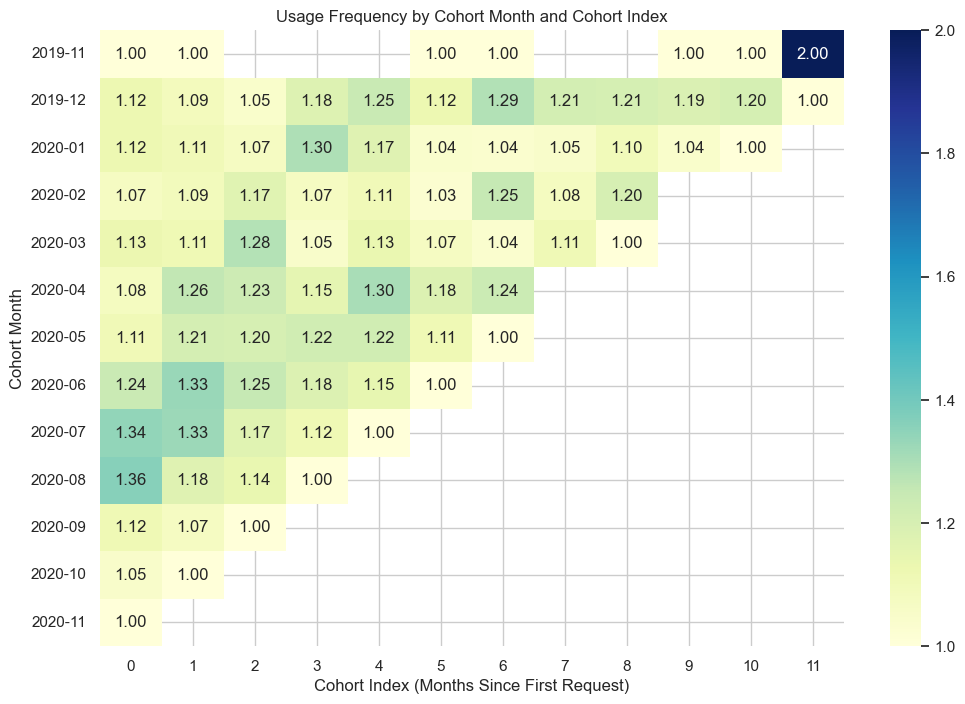

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_usage_frequency, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Usage Frequency by Cohort Month and Cohort Index")
plt.ylabel("Cohort Month")
plt.xlabel("Cohort Index (Months Since First Request)")
plt.show()


## 2. Bar chart for Revenue by Cohort

In [5]:
import pandas as pd
import seaborn as sns

#creating a user_df as a copy of df_cash
user_df = df_cash.copy()

#modifying user_df so that it only contains the columns we need to display revenue data

user_df = user_df.drop(columns=['id', 'status', 'updated_at',
       'moderated_at', 'deleted_account_id', 'reimbursement_date',
       'cash_request_received_date', 'money_back_date', 'transfer_type',
       'send_at', 'recovery_status', 'reco_creation', 'reco_last_update'])

#transforming the created_at column to datetime
user_df['created_at'] = pd.to_datetime(user_df['created_at'])

#aggregating to define the cohorts in form of df

first_requests = user_df.sort_values(by='created_at').drop_duplicates(subset='user_id', keep= 'first') #makes sure only the first cash requests are accounted for
first_requests['created_at'] = first_requests['created_at'].dt.tz_localize(None) #this code avoids timezone issues while creating the cohort column
monthly_counts = first_requests['created_at'].dt.to_period('M').value_counts().sort_index()

#adding the cohort column to first_requests
first_requests['cohort'] = first_requests['created_at'].dt.to_period('M')

#creating the cohort_revenue variable

cohort_revenue = first_requests.groupby('cohort')['amount'].sum().reset_index() 

C:\Users\Mirko\AppData\Local\Temp\ipykernel_2688\2812574957.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


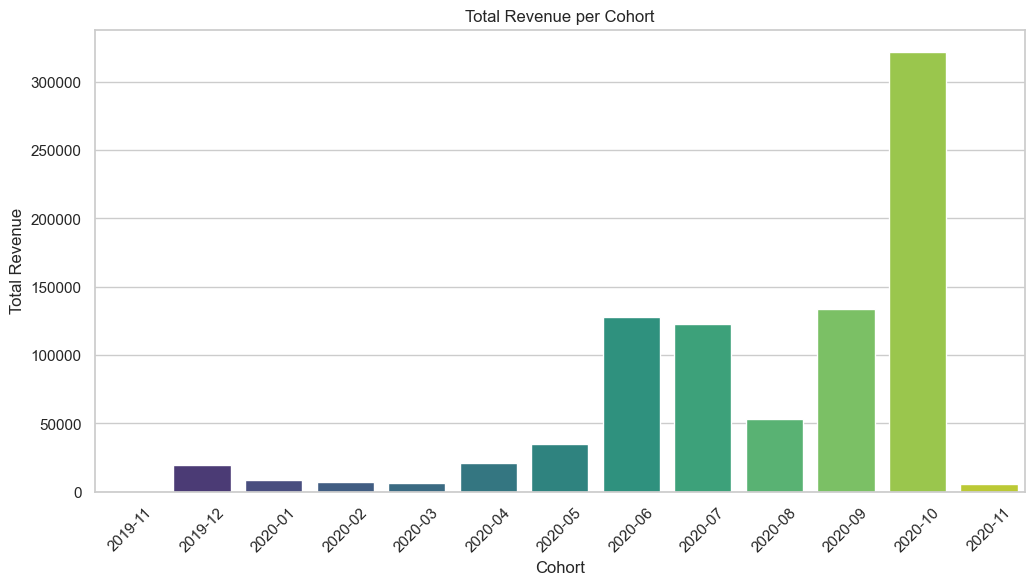

In [24]:
#creating the bar plot

sns.barplot(
    x='cohort',
    y='amount',
    data=cohort_revenue,
    palette='viridis'
)
plt.xticks(rotation=45)
plt.xlabel("Cohort")
plt.ylabel("Total Revenue")
plt.title("Total Revenue per Cohort")

plt.show()

This analysis clearly shows how the **October 2020 cohort** is the one with the highest revenue.
Reason for this is the fact that this cohort has also the highest count of new customers of the calendar year 2019-2020.

## 3. Bar plot for Incident Rate by Cohort (e.g., for month 0)


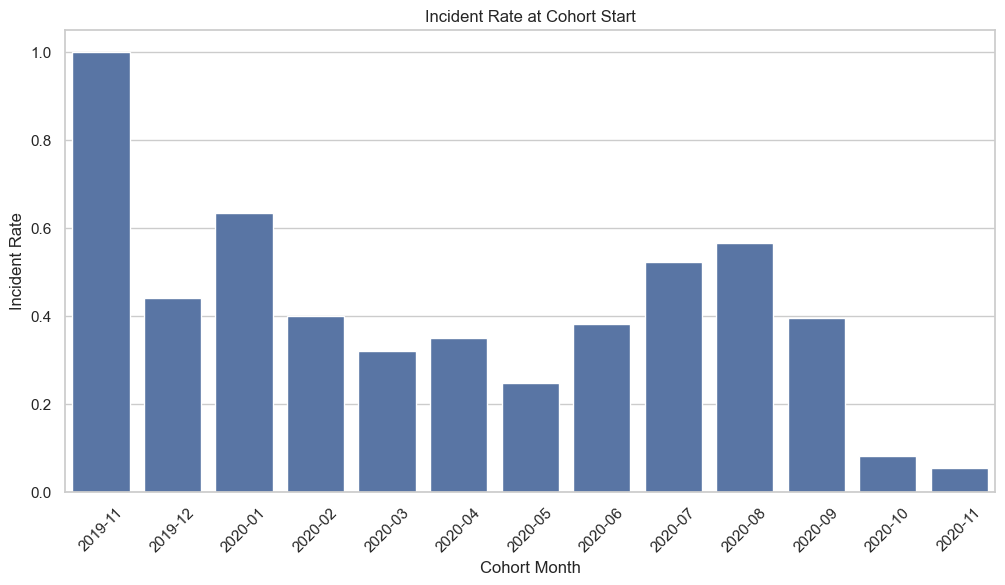

In [10]:
month0 = usage_summary[usage_summary['cohort_index']==0]
sns.barplot(data=month0, x='cohort_month', y='incident_rate')
plt.xticks(rotation=45)
plt.title('Incident Rate at Cohort Start')
plt.ylabel('Incident Rate')
plt.xlabel('Cohort Month')
plt.show()

## 4. Heatmap of user retention rates

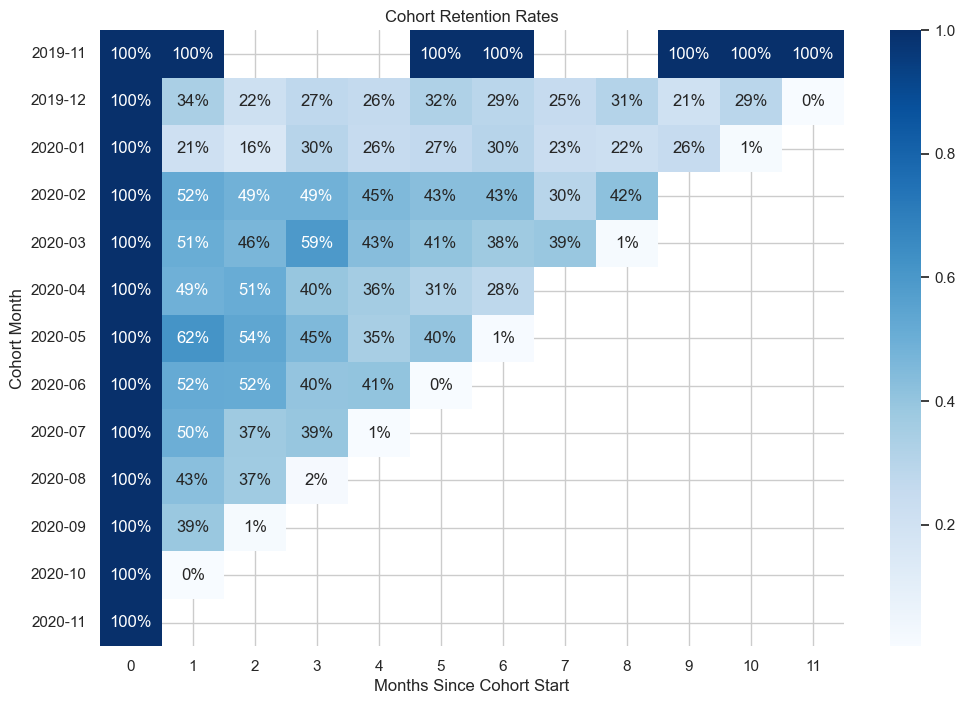

In [11]:
plt.figure(figsize=(12,8))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='Blues')
plt.title('Cohort Retention Rates')
plt.ylabel('Cohort Month')
plt.xlabel('Months Since Cohort Start')
plt.show()